In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from PIL import Image
# import tensorflow as tf
from sklearn import decomposition
import cv2

In [3]:
labels =  ['call_me', 'fingers_crossed', 'okay', 'paper', 'peace', 'rock', 'rock_on', 'scissor', 'thumbs', 'up']

In [4]:
# if no dataset folder, extract it
if not os.path.exists('datasets/'):
    !unzip -q datasets.zip

In [5]:
images = []
train_labels = []
for label_name in labels:
    folder_path = 'datasets/HandGesture/images/' + label_name
    for filename in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, filename))
        if img.mode != 'L':
            img = img.convert('L')
        img_arr = np.array(img)
        images.append(img_arr)
        train_labels.append(label_name)
train_images = np.array(images)
print(train_images.shape)

(5243, 195, 240)


In [6]:
X = train_images.reshape(train_images.shape[0], -1)

In [7]:
X.shape

(5243, 46800)

In [8]:
train_images.shape

(5243, 195, 240)

# Feature Extraction using PCA

In [9]:
standardized_scalar = StandardScaler()
standardized_data = standardized_scalar.fit_transform(X)
standardized_data.shape

(5243, 46800)

In [10]:
# cov_matrix = np.matmul(standardized_data.T, standardized_data)
# cov_matrix.shape

In [11]:
pca = decomposition.PCA(n_components = 2)
principal_components = pca.fit_transform(standardized_data)

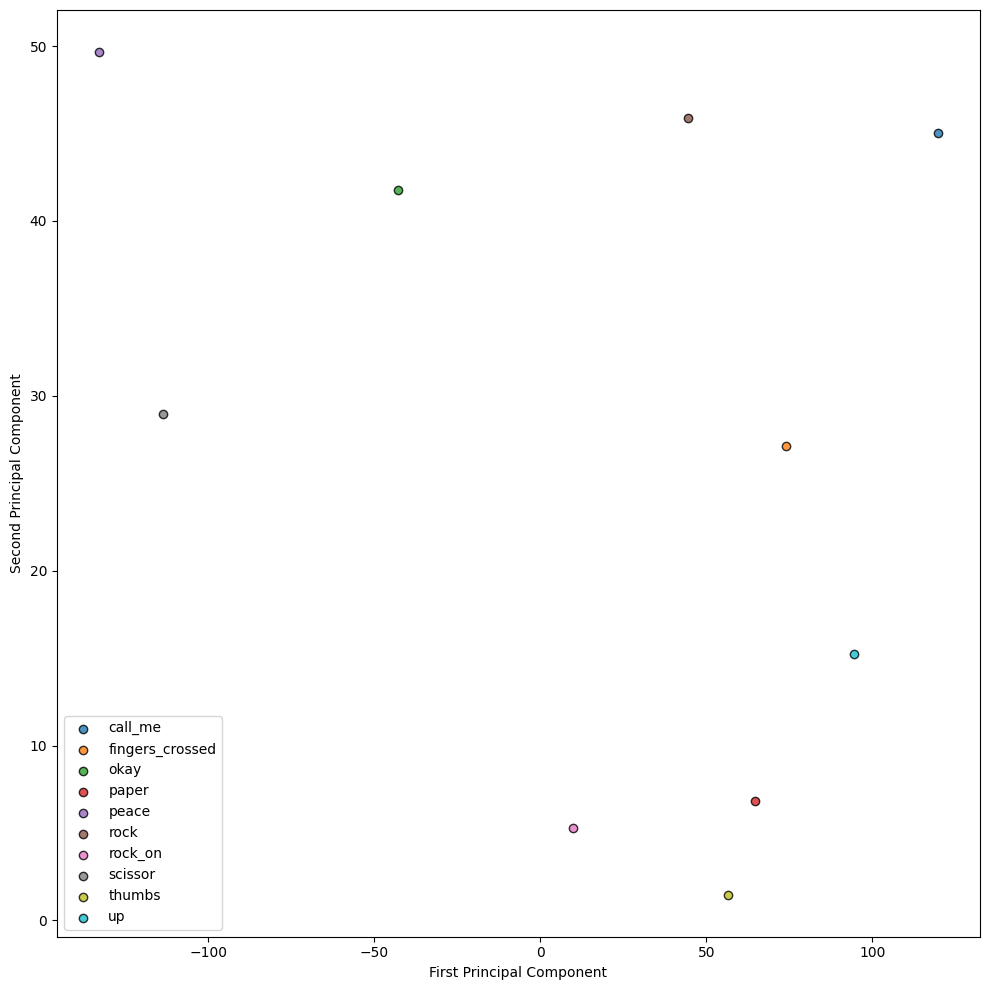

In [12]:
plt.figure(figsize=(10, 10))

colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))

for label, color in zip(labels, colors):
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1], 
                c=[color], label=label, edgecolors='k', alpha=0.8)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Feature Extration with HOG

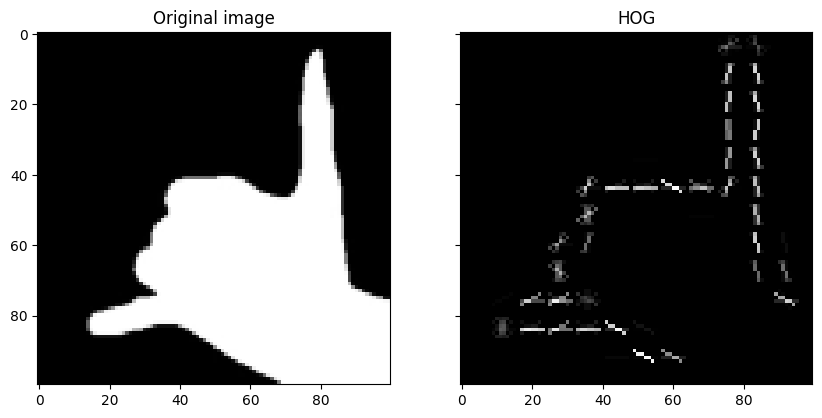

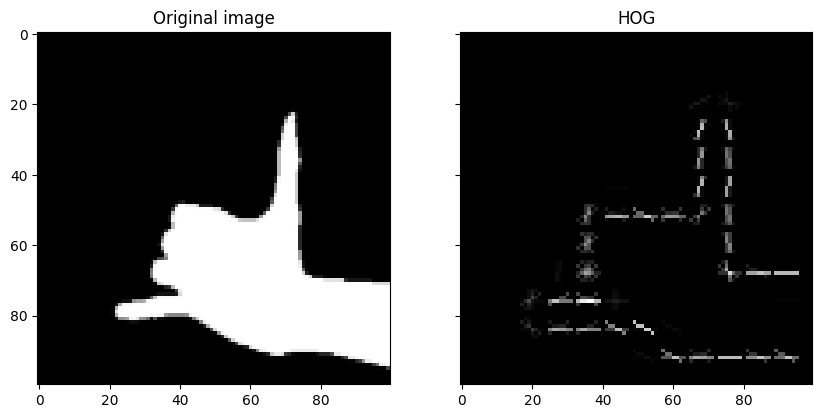

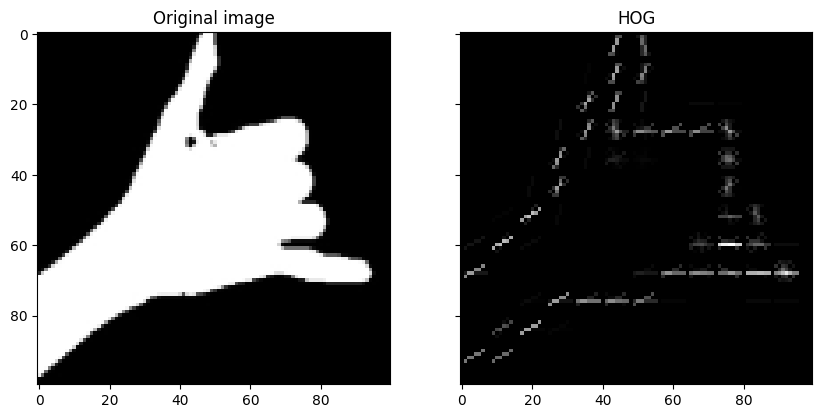

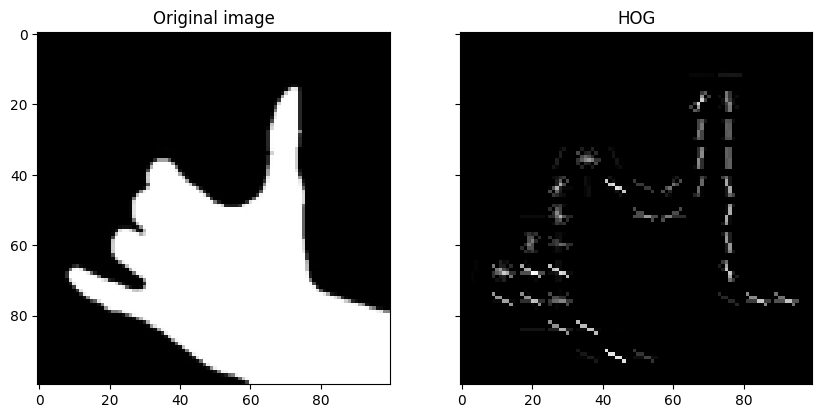

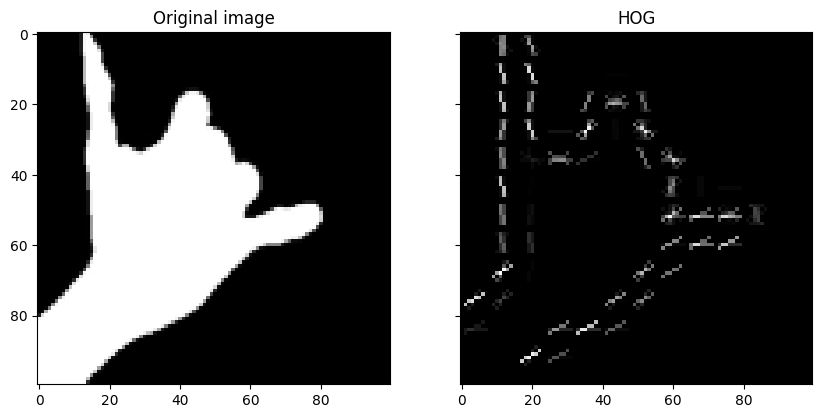

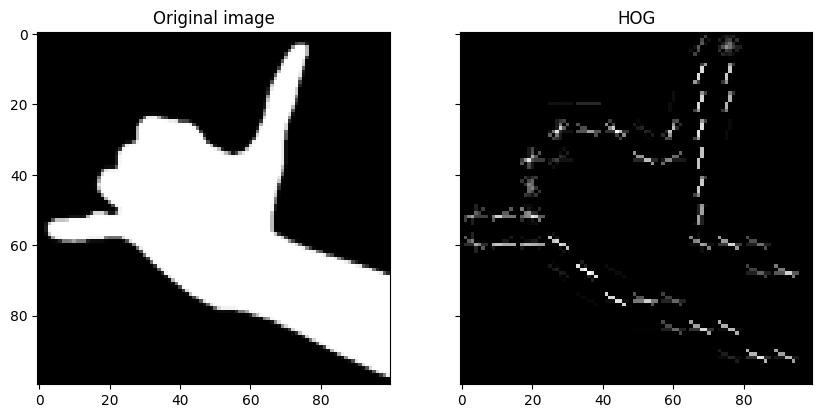

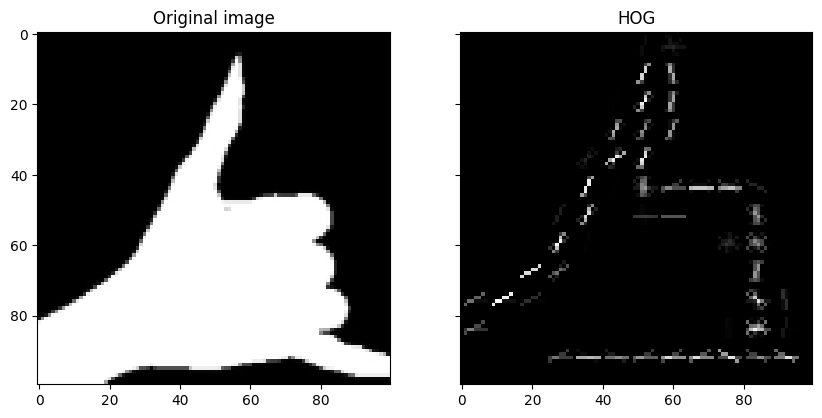

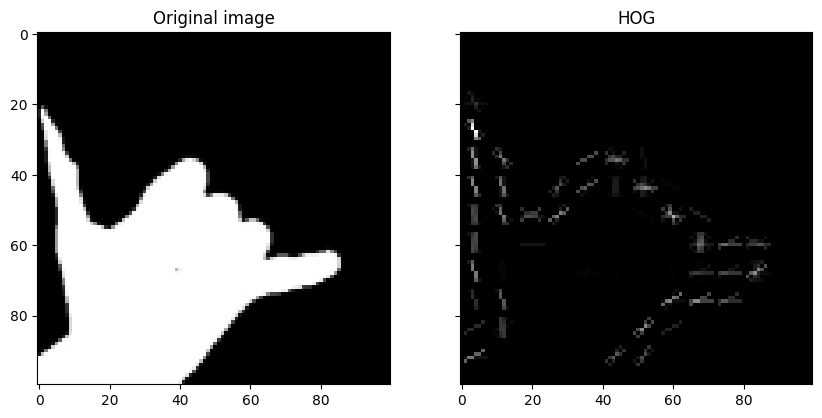

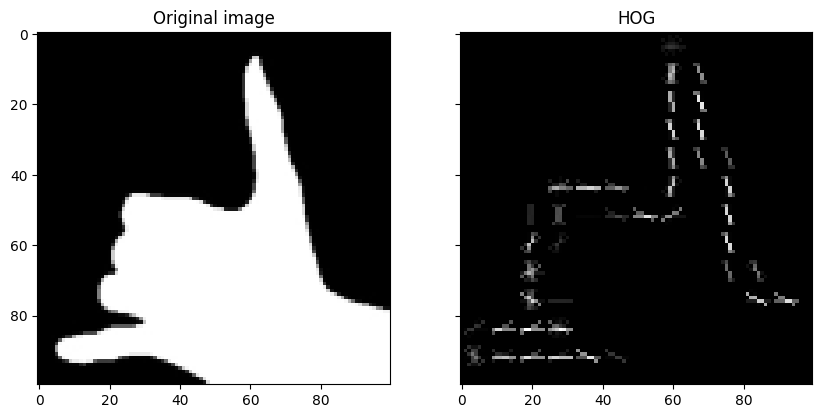

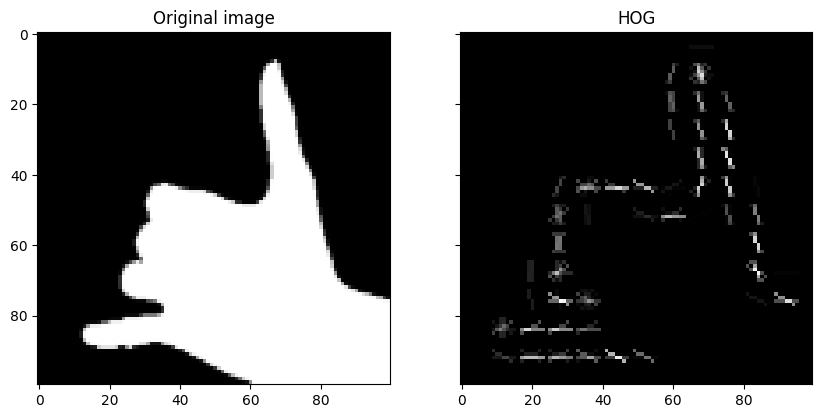

In [13]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt
import io


fds = []
hog_img_list = []
ori_img_list = []

max_hog_display = 10  # Display 10 HOG images, change it if different number of HOG images is desired
count = 0

for i in range(len(train_images)):
    img_resized = resize(train_images[i], (100,100)) 

    fd, hog_img = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=True)
    
    fds.append(fd)
    
    if count < max_hog_display:
        hog_img_list.append(hog_img)
        ori_img_list.append(img_resized)
    
    count +=1
    

for i in range(len(hog_img_list)):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True) 

    ax1.imshow(ori_img_list[i], cmap=plt.cm.gray) 
    ax1.set_title('Original image') 

    # Rescale histogram
    hog_image_rescaled = exposure.rescale_intensity(hog_img_list[i], in_range=(0, 10)) 

    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
    ax2.set_title('HOG')

    plt.show()

# Feature Extration with K-Means

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([8, 8, 0, ..., 7, 9, 2], dtype=int32)

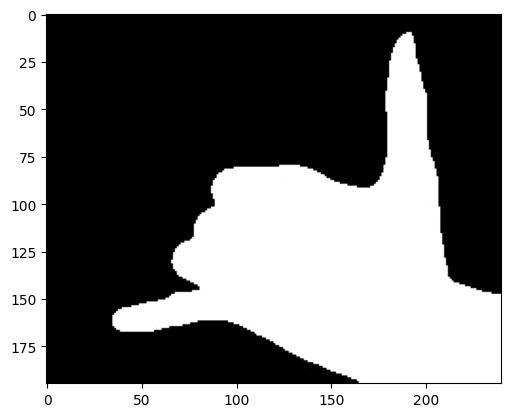

In [41]:
img = train_images[0] # warning: this is a uint8
plt.imshow(img, cmap=plt.cm.gray)

'''
This code will find K clusters based on PIXEL VALS. This doesn't work for binary imgs!

# Run K-Means
K = 20                                  # no of clusters
data = np.float32(img.reshape(-1,1))    # reshape to a 45600x1 array
bestLabels = None                       # store the cluster indices for each sample 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0) # termination, max_iter, epsilon
attempts = 10                           # no of times to repeat KMeans w/ dif initial labelings
flags = cv2.KMEANS_PP_CENTERS           # how to specify cluster centers

compactness, label, center = cv2.kmeans(data,K,None,criteria,attempts,flags)

# Display the clusters on the image
res = center.astype(np.uint8)[label.flatten()]
res = res.reshape((img.shape))

plt.imshow(res, cmap=plt.cm.gray)
'''
from sklearn.cluster import KMeans, MiniBatchKMeans

# Reshape data to normalized 1D float arrays
X = train_images.reshape(len(train_images),-1)
X = X.astype(float) / 255.0

# Perform K Means
K = len(labels)
kmeans = MiniBatchKMeans(n_clusters = K)
kmeans.fit(X)

kmeans.labels_

(5243,)
(10, 46800)


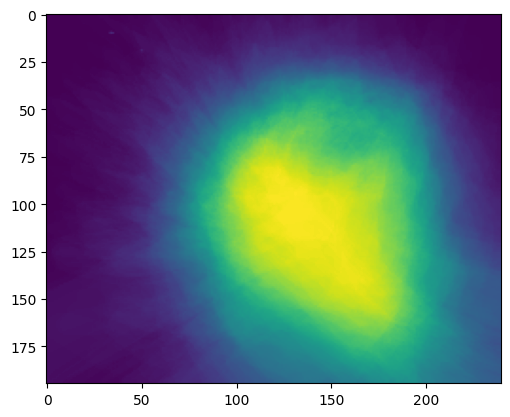

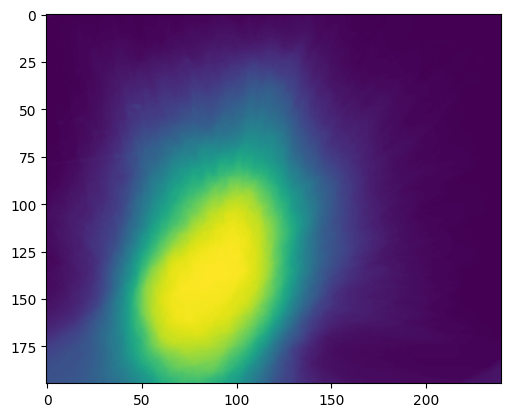

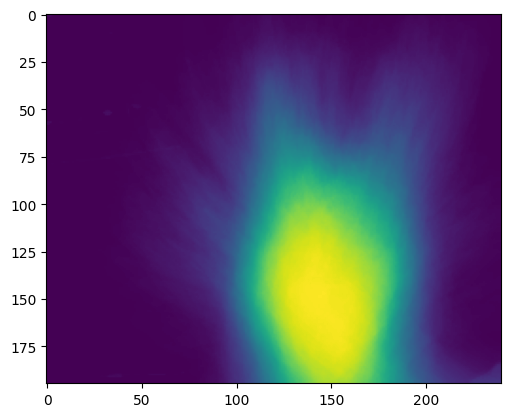

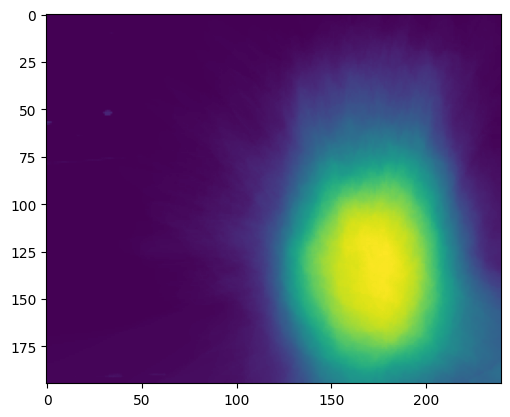

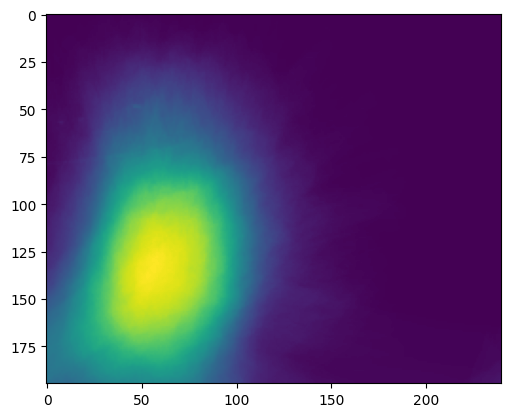

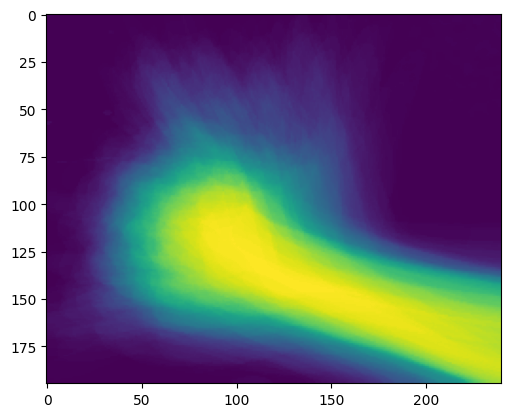

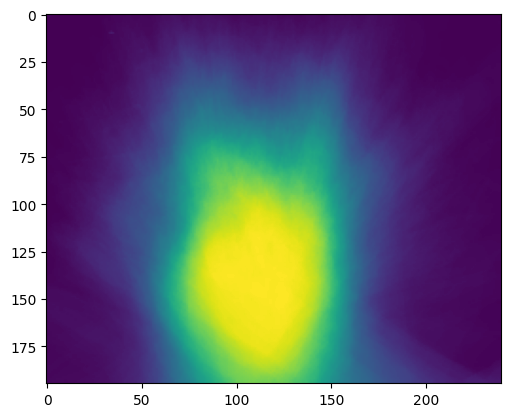

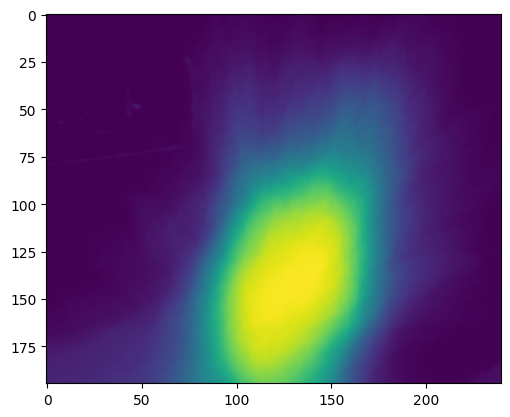

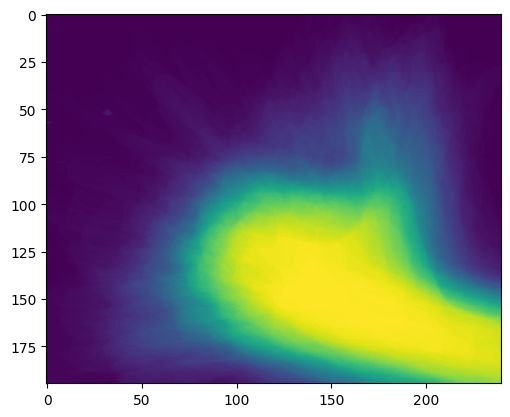

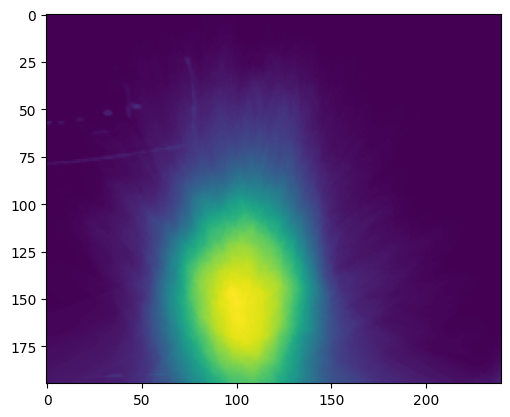

In [42]:
print(kmeans.labels_.shape) # no. of images
print(kmeans.cluster_centers_.shape) # K clusters x 46800 pixels

for i in range(len(kmeans.cluster_centers_)):
    # Reformat clusters to uint8
    center = kmeans.cluster_centers_[i].reshape((img.shape))
    center *= 255
    center = center.astype(np.uint8)

    # Plot images
    plt.imshow(center)
    plt.show()